### ISIC 2018 Skin Lesion Classification - EfficientNet B1



In [1]:
%%capture
!pip install -r requirements.txt


In [2]:
# Cell 1: Import các module và cấu hình
import warnings
warnings.filterwarnings('ignore')

import sys
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Import custom modules từ thư mục scr
from scr.config import *
from scr.data_processing import load_all_data
from scr.dataset import ISICDataset
from scr.transforms import get_train_transform, get_val_transform
from scr.model import build_model, count_parameters, load_checkpoint, save_checkpoint, print_model_info
from scr.train import train_one_epoch, create_dataloaders, get_optimizer, get_scheduler, get_criterion
from scr.evaluate import evaluate, plot_confusion_matrix, print_classification_report, create_submission, visualize_predictions

# Set random seed
set_seed(SEED)

# Print configuration
print_config()

print(f"\n✓ All modules imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

CONFIGURATION
Device: cpu
Random Seed: 42

Model: efficientnet_b1
Input Size: 224x224
Number of Classes: 7

Batch Size: 16
Learning Rate: 0.0001
Weight Decay: 0.0001
Number of Epochs: 10
Early Stop Patience: 2

Model Path: outputs\models\efficientnet_b1_isic2018.pt

✓ All modules imported successfully!
PyTorch version: 2.9.1+cpu
CUDA available: False


In [3]:
# Cell 2: Load và chuẩn bị dữ liệu

# Load all data
df_train, df_val, df_test, label2idx, idx2label, num_classes, use_weighted_sampler = load_all_data(
    PATH_TRAIN_CSV, PATH_VAL_CSV, PATH_TEST_CSV,
    DIR_TRAIN_IMG, DIR_VAL_IMG, DIR_TEST_IMG
)

# Store label mappings in config (for checkpoint saving)
LABEL2IDX = label2idx
IDX2LABEL = idx2label

# Create datasets
train_transform = get_train_transform()
val_transform = get_val_transform()

train_dataset = ISICDataset(df_train, transform=train_transform)
val_dataset = ISICDataset(df_val, transform=val_transform)
test_dataset = ISICDataset(df_test, transform=val_transform)

print(f"\n✓ Datasets created:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

# Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    df_train, df_val, df_test,
    train_dataset, val_dataset, test_dataset,
    BATCH_SIZE, NUM_WORKERS, use_weighted_sampler
)

print(f"\n✓ Dataloaders created:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Val: {len(val_loader)} batches")
print(f"  Test: {len(test_loader)} batches")


LOADING DATA

=== TRAIN DATASET ===
Total samples: 10015

Label distribution:
  AKIEC: 327 (3.27%)
  BCC: 514 (5.13%)
  BKL: 1099 (10.97%)
  DF: 115 (1.15%)
  MEL: 1113 (11.11%)
  NV: 6705 (66.95%)
  VASC: 142 (1.42%)

=== VAL DATASET ===
Total samples: 193

Label distribution:
  AKIEC: 8 (4.15%)
  BCC: 15 (7.77%)
  BKL: 22 (11.40%)
  DF: 1 (0.52%)
  MEL: 21 (10.88%)
  NV: 123 (63.73%)
  VASC: 3 (1.55%)

=== TEST DATASET ===
Total samples: 1512

Label distribution:
  AKIEC: 43 (2.84%)
  BCC: 93 (6.15%)
  BKL: 217 (14.35%)
  DF: 44 (2.91%)
  MEL: 171 (11.31%)
  NV: 909 (60.12%)
  VASC: 35 (2.31%)

=== LABEL MAPPING ===
Number of classes: 7
  0: AKIEC
  1: BCC
  2: BKL
  3: DF
  4: MEL
  5: NV
  6: VASC

=== CLASS IMBALANCE ANALYSIS ===
Class imbalance ratio: 58.30
Max class count: 6705
Min class count: 115
⚠ High class imbalance detected (ratio > 3.0).
   Will use WeightedRandomSampler for balanced training.

DATA LOADING COMPLETE

✓ Datasets created:
  Train: 10015 samples
  Val: 193 

✅ Figure saved to: outputs/figures/dataset_overview.png
✅ Figure saved to: outputs/figures/class_distribution_comparison.png


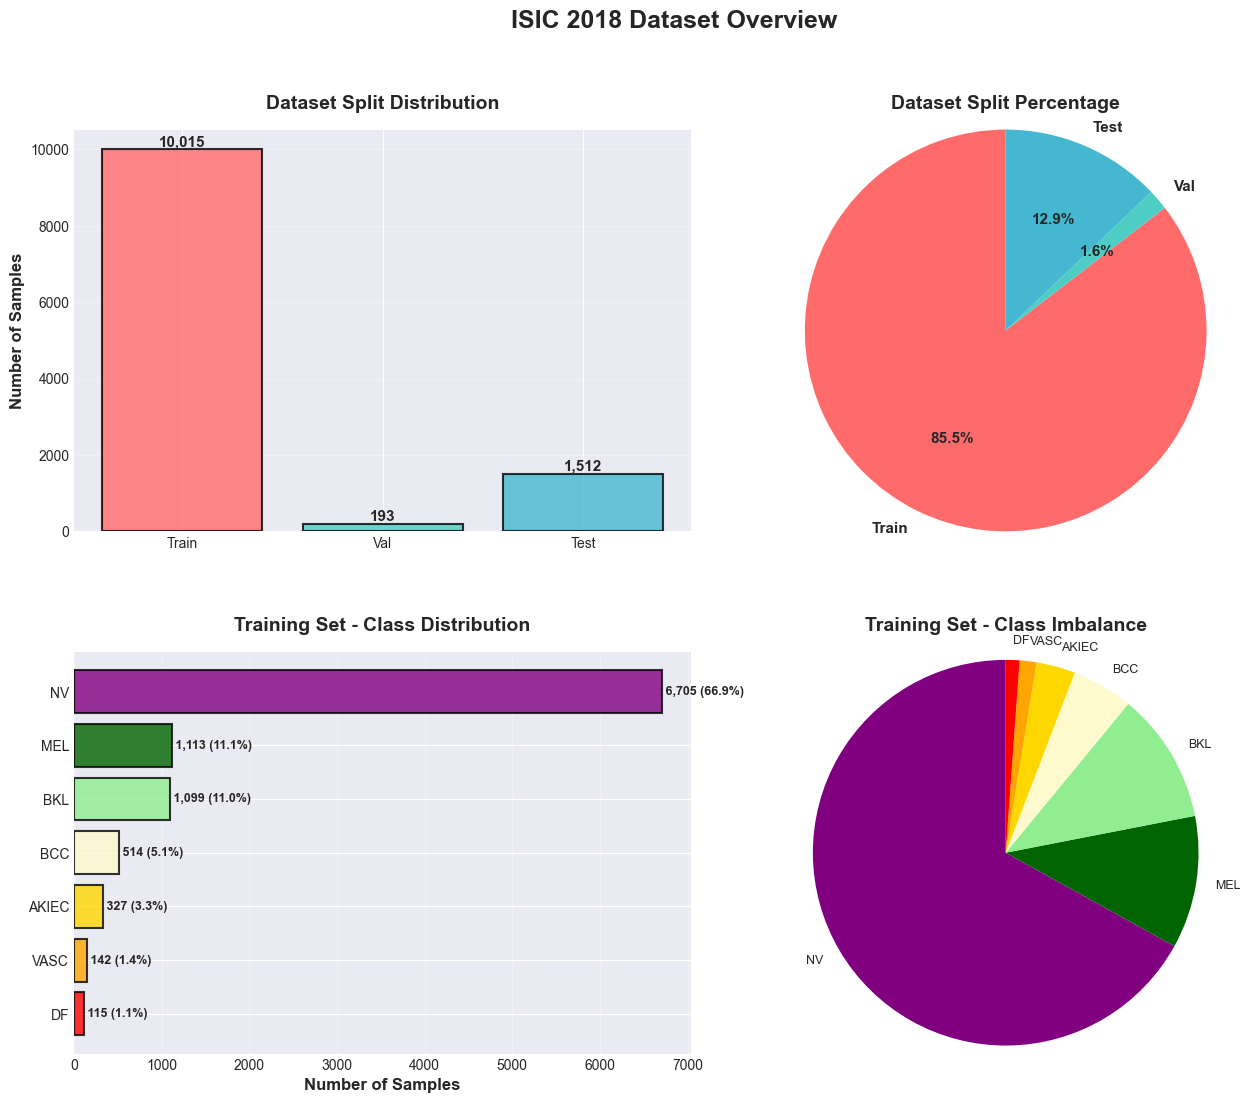

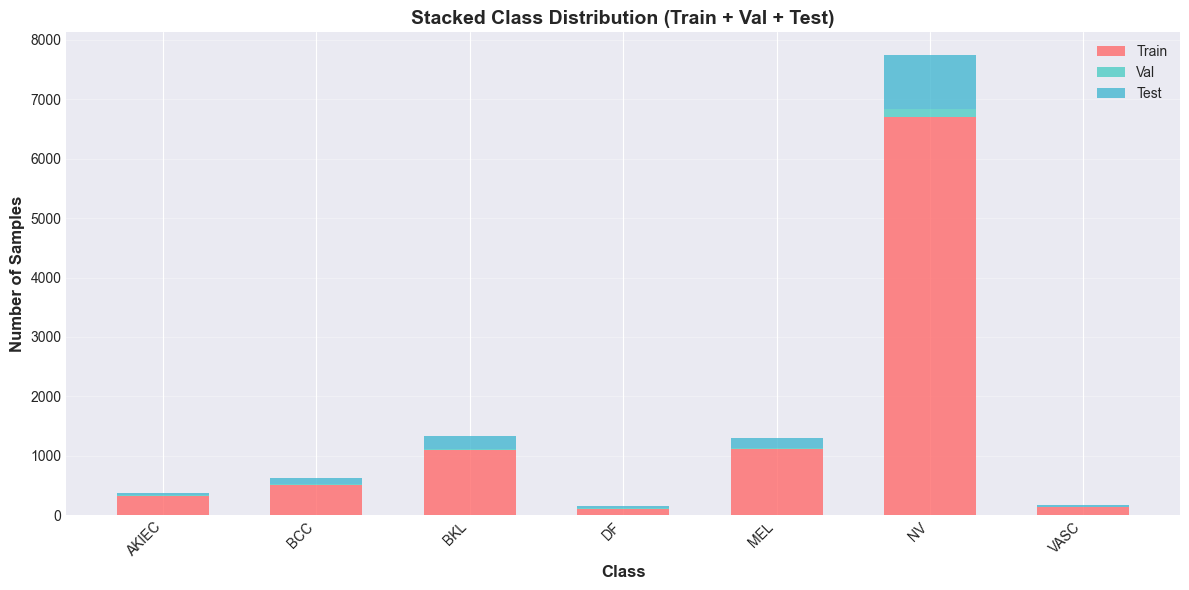

In [4]:
# Visualization: Dataset Overview
from scr.visualize_dataset import plot_dataset_overview, plot_class_distribution_comparison

# Tạo overview figure
fig1 = plot_dataset_overview(df_train, df_val, df_test, 
                             save_path='outputs/figures/dataset_overview.png')
# Tạo comparison figure  
fig2 = plot_class_distribution_comparison(df_train, df_val, df_test,
                                         save_path='outputs/figures/class_distribution_comparison.png')
plt.show()

In [5]:
# Cell 3: Khởi tạo model và training components

# Build model
model = build_model(num_classes=num_classes, pretrained=True, model_name=MODEL_NAME)
model = model.to(DEVICE)

# Print model info
print_model_info(model, MODEL_NAME.upper())

# Setup training components
optimizer = get_optimizer(model, LEARNING_RATE, WEIGHT_DECAY)
scheduler = get_scheduler(optimizer, NUM_EPOCHS, USE_COSINE_SCHEDULER)
criterion = get_criterion(USE_LABEL_SMOOTHING, LABEL_SMOOTHING)

# Initialize mixed precision scaler
from torch.cuda.amp import GradScaler
scaler = GradScaler() if torch.cuda.is_available() else None

print("\n✓ Model and training components initialized!")


MODEL INFORMATION
Model: EFFICIENTNET_B1
Total parameters: 6,522,151
Trainable parameters: 6,522,151
✓ Optimizer: AdamW (lr=0.0001, weight_decay=0.0001)
✓ Scheduler: CosineAnnealingLR (T_max=10)
✓ Loss: CrossEntropyLoss

✓ Model and training components initialized!


In [6]:
# Cell 4: Training Loop (Optimized for CPU)

# Training history
history = {
    'epoch': [], 'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_bal_acc': [], 'lr': []
}

# Best model tracking
best_val_f1 = 0.0
best_epoch = 0
patience_counter = 0
start_epoch = 0

# Load existing checkpoint if exists
import os
if os.path.exists(MODEL_PATH):
    checkpoint = load_checkpoint(model, optimizer, MODEL_PATH, DEVICE)
    start_epoch = checkpoint.get('epoch', 0)
    best_val_f1 = checkpoint.get('best_val_f1', 0.0)
    best_epoch = checkpoint.get('best_epoch', 0)
    if 'history' in checkpoint:
        history = checkpoint['history']
    print(f"📂 Resumed from epoch {start_epoch}")
else:
    print("🆕 Starting fresh training")

print(f"\n⚙️ Training Configuration:")
print(f"  • Epochs: {NUM_EPOCHS}")
print(f"  • Batch Size: {BATCH_SIZE}")
print(f"  • Validate every: {VAL_EVERY_N_EPOCHS} epochs")
print(f"  • Save every: {SAVE_EVERY_N_EPOCHS} epochs")
print(f"  • Early Stop Patience: {EARLY_STOP_PATIENCE}\n")

# Training loop
for epoch in range(start_epoch, NUM_EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print('='*60)
    
    # Train
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    train_pbar = tqdm(train_loader, desc=f"Training", leave=False)
    for images, labels, _ in train_pbar:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    from sklearn.metrics import accuracy_score
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = accuracy_score(all_labels, all_preds)
    
    print(f"📈 Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    
    # Validate only every N epochs
    should_validate = (epoch + 1) % VAL_EVERY_N_EPOCHS == 0 or (epoch + 1) == NUM_EPOCHS
    
    if should_validate:
        print("🔍 Running validation...")
        val_loss, val_acc, val_f1, val_bal_acc, _, _, _, _ = evaluate(model, val_loader, criterion, DEVICE)
        print(f"📊 Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")
        
        # Check for best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch + 1
            patience_counter = 0
            print(f"✅ New best model! F1: {val_f1:.4f}")
        else:
            patience_counter += 1
            print(f"⏳ No improvement ({patience_counter}/{EARLY_STOP_PATIENCE})")
        
        # Record history
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_bal_acc'].append(val_bal_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])
    
    # Update learning rate
    if USE_COSINE_SCHEDULER:
        scheduler.step()
    
    # Save checkpoint periodically
    should_save = (epoch + 1) % SAVE_EVERY_N_EPOCHS == 0 or (epoch + 1) == NUM_EPOCHS
    if should_save:
        save_checkpoint(model, optimizer, epoch + 1, best_val_f1, best_epoch,
                       val_f1 if should_validate else 0.0, 
                       val_acc if should_validate else 0.0, 
                       history, label2idx, idx2label, num_classes, MODEL_PATH)
        print(f"💾 Checkpoint saved at epoch {epoch+1}")
    
    # Early stopping (only check when we validate)
    if should_validate and patience_counter >= EARLY_STOP_PATIENCE:
        print(f"\n⚠️ Early stopping at epoch {epoch + 1}")
        break

print(f"\n{'='*60}")
print(f"✅ Training Complete!")
print(f"📊 Best: Epoch {best_epoch} | F1: {best_val_f1:.4f}")
print(f"💾 Model saved: {MODEL_PATH}")
print('='*60)

🆕 Starting fresh training

⚙️ Training Configuration:
  • Epochs: 10
  • Batch Size: 16
  • Validate every: 3 epochs
  • Save every: 1 epochs
  • Early Stop Patience: 2


Epoch 1/10


Training:   0%|          | 0/626 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Cell 5: Đánh giá trên Validation Set

# Load best model
print("Loading best model...")
checkpoint = load_checkpoint(model, None, MODEL_PATH, DEVICE)

# Evaluate on validation set
print("\nEvaluating on validation set...")
val_loss, val_acc, val_f1, val_bal_acc, val_preds, val_labels, val_probs, val_image_ids = evaluate(
    model, val_loader, criterion, DEVICE
)

print(f"\nValidation Results:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  Macro F1: {val_f1:.4f}")
print(f"  Balanced Accuracy: {val_bal_acc:.4f}")

# Confusion Matrix
plot_confusion_matrix(
    val_labels, val_preds, idx2label,
    save_path=os.path.join(DIR_FIGURES, 'val_confusion_matrix.png'),
    title='Validation Confusion Matrix'
)

# Classification Report
print_classification_report(val_labels, val_preds, idx2label)

In [ ]:
# Cell 6: Đánh giá trên Test Set

# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_acc, test_f1, test_bal_acc, test_preds, test_labels, test_probs, test_image_ids = evaluate(
    model, test_loader, criterion, DEVICE
)

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Macro F1: {test_f1:.4f}")
print(f"  Balanced Accuracy: {test_bal_acc:.4f}")

# Confusion Matrix
plot_confusion_matrix(
    test_labels, test_preds, idx2label,
    save_path=os.path.join(DIR_FIGURES, 'test_confusion_matrix.png'),
    title='Test Confusion Matrix'
)

# Classification Report
print_classification_report(test_labels, test_preds, idx2label)

# Create submission
submission_path = os.path.join(DIR_SUBMISSIONS, 'test_predictions.csv')
submission_df = create_submission(test_image_ids, test_preds, test_probs, idx2label, submission_path)

In [ ]:
# Cell 7: Inference Demo

# Demo images
demo_images = [
    (os.path.join(DIR_TEST_IMG, "ISIC_0034524.jpg"), "ISIC_0034524"),
    (os.path.join(DIR_VAL_IMG, "ISIC_0034321.jpg"), "ISIC_0034321"),
]

# Visualize predictions
visualize_predictions(
    model, demo_images, val_transform, DEVICE, idx2label,
    save_path=os.path.join(DIR_FIGURES, 'inference_demo.png'),
    top_k=3
)

print("\n✅ Inference demo completed!")

In [ ]:
# Cell 8: Vẽ Training History

if len(history['epoch']) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['epoch'], history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['epoch'], history['val_loss'], label='Val Loss', marker='s')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history['epoch'], history['train_acc'], label='Train Acc', marker='o')
    axes[0, 1].plot(history['epoch'], history['val_acc'], label='Val Acc', marker='s')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 Score
    axes[1, 0].plot(history['epoch'], history['val_f1'], label='Val F1', marker='s', color='green')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].set_title('Validation F1 Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 1].plot(history['epoch'], history['lr'], label='Learning Rate', marker='o', color='red')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(DIR_FIGURES, 'training_history.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Training history plotted and saved!")
else:
    print("No training history available.")